<a href="https://www.kaggle.com/code/nguyenhau441002/15keypoints?scriptVersionId=98979480" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train_data = pd.read_csv('../input/facial-keypoints-detection/training/training.csv')  
test_data = pd.read_csv('../input/facial-keypoints-detection/test (8)/test.csv')

In [3]:
#The dimension of variable train_data is (7049,31)
#print(train_data.shape)
#train_data.head().T

In [4]:
#Check null values in train_data

#train_data.isnull().any().value_counts()

In [5]:
train_data.fillna(method = 'ffill',inplace = True)
#train_data.isnull().any().value_counts()

In [6]:
y_train=train_data.drop(['Image'],axis=1)
#print(y_train.shape)
y_train=np.array(y_train,dtype = 'uint8')

In [7]:
#train_data.info()

In [8]:
#Data in "Image" cell have 2D dimension
imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
   
    imag.append(img)
print("Convert process completed")

#Single cell have 96*96=9612 values,so array 'image_list' have size (7049,9216)
image_list = np.array(imag,dtype = 'uint8')
#print(image_list.shape)

Convert process completed


In [9]:
#And then, if we want to display gray scale image, we have to convert to (7049,96,96,1)
X_train = image_list.reshape(-1,96,96,1)
#print(X_train.shape)

In [10]:
x_test=[]
for i in range(0,7049):
    for j in range(0,30,2):
        x_plot=y_train[i][j]
        x_test.append(x_plot)
x_test=np.array(x_test,dtype = 'uint8').reshape(7049,15)
#print(x_test.shape)

In [11]:
y_test=[]
for i in range(0,7049):
    for j in range(1,30,2):
        y_plot=y_train[i][j]
        y_test.append(y_plot)
y_test=np.array(y_test,dtype = 'uint8').reshape(7049,15)
#print(y_test.shape)

In [12]:
#plt.figure(figsize=(20,20))
#for i in range(16):     # Number 9 has mean loop run from index 0 ->8  (9 times)
 #   plt.subplot(4,4,i+1)
  #  plt.imshow(X_train[i],cmap='gray')
   # plt.scatter(x_test[i],y_test[i],color="yellow")
#plt.show()

(49343, 96, 96, 1)
(49343, 30)


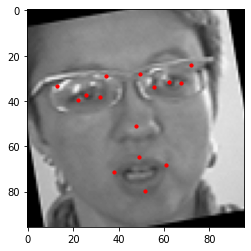

In [13]:
import cv2
from math import sin, cos, pi

def aug_rotation(X, Y):
    rotation_angles = [10,20,30]
    
    rotated_images = []
    rotated_keypoints = []
    
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            rot = cv2.getRotationMatrix2D((48,48), angle, 1.)
            angle_rad = -angle*pi/180.
            
            for image in X:
                rotated_image = cv2.warpAffine(image, rot, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
                
            for keypoint in Y:
                rotated_keypoint = keypoint - 48.
                
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints



X_train_rot, Y_train_rot = aug_rotation(X_train,y_train)
fig, axis = plt.subplots()
img_rot = X_train_rot[10].reshape(96,96)
axis.imshow(img_rot, cmap='gray')
axis.scatter(Y_train_rot[10][0::2], Y_train_rot[10][1::2], s=10, c='r')


X_train_augumentation= np.concatenate((X_train, X_train_rot))
y_train_augumentation = np.concatenate((y_train, Y_train_rot))

print(X_train_augumentation.shape)
print(y_train_augumentation.shape)

(77188, 96, 96, 1)
(77188, 30)


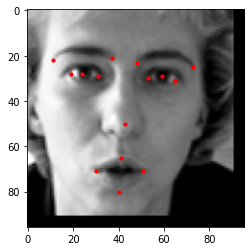

In [14]:
def aug_shift(X, Y):
    pixel_shifts = [5]
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            sh = np.float32([[1,0,shift_x],[0,1,shift_y]])
            
            for image, keypoint in zip(X, Y):
                shifted_image = cv2.warpAffine(image, sh, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

X_train_shift, Y_train_shift = aug_shift(X_train,y_train)
fig, axis = plt.subplots()
img_sh = X_train_shift[1].reshape(96,96)
axis.imshow(img_sh, cmap='gray')
axis.scatter(Y_train_shift[1][0::2], Y_train_shift[1][1::2], s=10, c='r')



X_train = np.concatenate((X_train_augumentation, X_train_shift))
y_train = np.concatenate((y_train_augumentation, Y_train_shift))

print(X_train.shape)
print(y_train.shape)

In [15]:
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Activation,BatchNormalization
from keras.layers import Flatten,Dense
from keras import optimizers

In [16]:
model = Sequential()

model.add(Convolution2D(16, (3,3), padding='same', activation='relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', activation='relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', activation='relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3), padding='same', activation='relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))
model.summary()

2022-06-21 19:12:29.154989: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1

In [17]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
#print(X_train.shape)
#print(y_train.shape)

In [21]:
#import numpy as np
#np.save('X_train.npy',X_train)
#np.save('y_train.npy',y_train)

In [22]:
X,X_test,Y,Y_test=train_test_split(X_train,y_train,test_size=0.15)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(65609, 96, 96, 1)
(65609, 30)
(11579, 96, 96, 1)
(11579, 30)


In [23]:
history=model.fit(X,Y,epochs=100,batch_size=128,verbose=1,validation_data=(X_test,Y_test),callbacks=[EarlyStopping(monitor='accuracy',patience=20)])

2022-06-21 19:12:31.798765: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
513/513 [==============================] - 192s 372ms/step - loss: 40.1264 - accuracy: 0.6514 - val_loss: 8.1816 - val_accuracy: 0.8111
Epoch 2/100
513/513 [==============================] - 190s 371ms/step - loss: 12.3440 - accuracy: 0.7609 - val_loss: 11.1096 - val_accuracy: 0.8125
Epoch 3/100
513/513 [==============================] - 192s 375ms/step - loss: 10.6024 - accuracy: 0.7855 - val_loss: 5.4949 - val_accuracy: 0.8327
Epoch 4/100
513/513 [==============================] - 192s 374ms/step - loss: 8.8254 - accuracy: 0.8094 - val_loss: 5.5666 - val_accuracy: 0.8537
Epoch 5/100
513/513 [==============================] - 193s 376ms/step - loss: 7.7235 - accuracy: 0.8271 - val_loss: 4.7759 - val_accuracy: 0.8473
Epoch 6/100
513/513 [==============================] - 193s 377ms/step - loss: 7.3469 - accuracy: 0.8390 - val_loss: 5.2717 - val_accuracy: 0.8448
Epoch 7/100
513/513 [==============================] - 191s 372ms/step - loss: 6.6392 - accuracy: 0.8499 - val_los

In [24]:
from keras.models import load_model

In [25]:
model.save("Facial_landmark_upgrade_5.h5")

In [26]:
#model=load_model("../input/trained-modelh5/Facial_landmark_upgrade_4.h5")

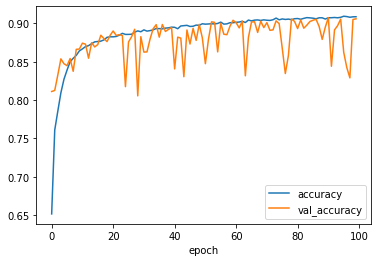

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'])
plt.show()

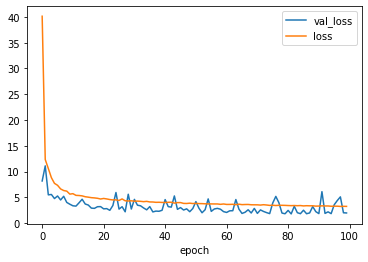

In [28]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.legend(['val_loss','loss'])
plt.show()

In [29]:
#Data in "Image" cell have 2D dimension
test_image = []
for i in range(0,1783):
    test_img = test_data['Image'][i].split(' ')
   
    test_image.append(test_img)
print("Convert process completed")

test_image = np.array(test_image,dtype = 'float')
print(test_image.shape)
#And then, if we want to display gray scale image, we have to convert to (7049,96,96,1)
test_image = test_image.reshape(-1,96,96,1)
print(test_image.shape)

Convert process completed
(1783, 9216)
(1783, 96, 96, 1)


In [30]:
import numpy as np
import cv2
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [31]:
from array import array
from keras.preprocessing.image import load_img, img_to_array, array_to_img

img = rgb2gray(cv2.imread('../input/trained-model/test_image2.jpg'));
img=np.array(img)
img=img.reshape(96,96,1)
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(96, 96, 1)


In [32]:
pred=model.predict(img.reshape(1,96,96,1))
print(pred.shape)

(1, 30)


In [33]:
x_test_pred=[]
for i in range(0,1):
    for j in range(0,30,2):
        x_plot_pred=pred[i][j]
        x_test_pred.append(x_plot_pred)
x_test_pred=np.array(x_test_pred).reshape(1,15)
print(x_test_pred.shape)

(1, 15)


In [34]:
y_test_pred=[]
for i in range(0,1):
    for j in range(1,30,2):
        y_plot_pred=pred[i][j]
        y_test_pred.append(y_plot_pred)
y_test_pred=np.array(y_test_pred).reshape(1,15)
print(y_test_pred.shape)

(1, 15)


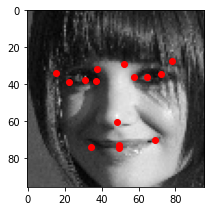

In [35]:
plt.figure(figsize=(15,15))
for i in range(1):     # Number 9 has mean loop run from index 0 ->8  (9 times)
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.scatter(x_test_pred[i],y_test_pred[i],color="red")
plt.show()